# "Machine Learning for Climate Predictions" Workshop
#### Jupyter Notebook prepared by Cindy Gonzales

Artificial intelligence (AI) methods have begun to show great promise in climate science applications. This notebooke will introduce and describe a dataset and methods to make machine learning predictions of a multiresolution climate model ensemble.

For more information on the dataset and methods used, please reference the paper:

[Machine Learning Predictions of Multi-Resolution Climate Model Ensembles– Anderson, G. J. and Lucas, D. D. (GRL: in review). IM release number: LLNL-JRNL-744178.](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018GL077049)

**Auspices Statement**: This work was performed under the auspices of the U.S. Department of Energy by Lawrence Livermore National Laboratory under Contract DE-AC52-07NA27344.

#### Downloading the data

Let's start by downloading the data locally. Uncomment this cell to run the following commands to download the dataset or follow the instructions in the paper to access the data.

**PRO TIP**: To uncomment a full cell, use `Ctrl` + `A` to select all lines then `Ctrl` + `/` to quick uncomment all selected lines.

In [43]:
# ! wget ftp://gdo148.ucllnl.org/multires-random-forest.tgz
# ! tar -xvzf multires-random-forest.tgz

#### Loading the needed packages and data

Now that we've downloaded the data, let's first import some needed packages that we can use such as numpy, pandas, matplotlib and useful functions from sklearn. We'll also need to read the data into a useable format.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import (
    ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
)
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

In [3]:
features = np.load('multi-resolution/multiresolution_params_and_metrics.npy')

In [4]:
df = pd.DataFrame(
    features, 
     columns=['cldfrc_rhminl', 'micromg_dcs', 'eddydiff_a2l', 'uwshcu_criqc', 'uwshcu_rkm',
              'uwshcu_rpen', 'zmconv_alfa', 'zmconv_c0_ocn', 'zmconv_dmpdz', 'zmconv_ke', 
              'zmconv_tau', 'resolution', 'TOA_energy_flux', 'precipitation']
)

In [5]:
df

,cldfrc_rhminl,micromg_dcs,eddydiff_a2l,uwshcu_criqc,uwshcu_rkm,uwshcu_rpen,zmconv_alfa,zmconv_c0_ocn,zmconv_dmpdz,zmconv_ke,zmconv_tau,resolution,TOA_energy_flux,precipitation
0,0.513158,0.750000,0.500000,0.200000,0.750000,1.000000,0.278943,0.826606,0.698970,0.231378,0.544417,1.0000,11.078644,3.287566e-08
1,0.000000,0.750000,0.500000,0.200000,0.750000,1.000000,0.278943,0.826606,0.698970,0.231378,0.544417,1.0000,0.900214,3.378267e-08
2,1.000000,0.750000,0.500000,0.200000,0.750000,1.000000,0.278943,0.826606,0.698970,0.231378,0.544417,1.0000,18.531844,3.236089e-08
3,0.513158,0.000000,0.500000,0.200000,0.750000,1.000000,0.278943,0.826606,0.698970,0.231378,0.544417,1.0000,8.339281,3.410277e-08
4,0.513158,1.000000,0.500000,0.200000,0.750000,1.000000,0.278943,0.826606,0.698970,0.231378,0.544417,1.0000,11.162554,3.275170e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,0.841311,0.550732,0.862211,0.771593,0.626219,0.712388,0.473620,0.937692,0.952484,0.795456,0.953037,0.0625,3.686973,3.562486e-08
902,0.420755,0.150635,0.879170,0.933833,0.374344,0.412366,0.253196,0.537597,0.920912,0.719474,0.022809,0.0625,-6.642911,3.608198e-08
903,0.016315,0.200030,0.430349,0.025959,0.347203,0.921252,0.008454,0.543158,0.114437,0.566006,0.151339,0.0625,-5.854439,3.636534e-08
904,0.522297,0.052848,0.662738,0.006282,0.277326,0.519419,0.704073,0.868487,0.069545,0.254931,0.286714,0.0625,4.026710,3.458463e-08


#### Looking at the data

Overall, the data has 906 rows and 14 columns. The columns correspond with features and the rows correspond with data points collected. We will use a subset of the data points to train a predictive model. 

First, let's briefly discuss what features are included. We collected these features by running simulations in a climate model repeatedly. We have 11 features that have been identified as important that span five physical schemes related to clouds, cloud microphysics, turbulent mixing, and deep and shallow convection. Below is a table describing the features and their expert-provided ranges of variation:

Description of features:

| Parameter | Scheme | Description | Range |
| --------- | ------ | ----------- | ----- |
| cldfrc_rhminl | Cloud processes | Humidity threshold for low clouds | \[0.8, 0.99\] |
| micromg_dcs | Microphysics | Autoconversion size threshold (ice to snow) | \[1.0E-4, 5.0E-4\] |
| eddydiff_a2l | Eddy diffusion | Moist entrainment enhancement | \[10.0, 50.0\] |
| uwshcu_criqc| Shallow convection | Maximum updraft condensate |\[0.0005, 0.0015\] |
| uwshcu_rkm | Shallow convection | Fractional updraft mixing efficiency | \[8.0, 16.0\] |
| uwshcu_rpen | Shallow convection | Penetrative entrainment efficiency | \[1.0, 10.0\] |
| zmconv_alfa | Deep convection | Initial cloud downdraft mass flux | \[0.05, 0.6\] |
| zmconv_c0_ocn | Deep convection | Precipitation efficiency over ocean | \[0.001, 0.1\] |
| zmconv_dmpdz | Deep convection | Mass entrainment rate | \[0.0002, 0.002\] |
| zmconv_ke | Deep convection | Evaporation efficiency | \[0.5E−6, 10.0E−6\] |
| zmconv_tau | Deep convection | Convective timescale | \[300, 28800\] |

#### Quick EDA

`.describe()` is a great function to start with as it shows us the relevant summary statistics. Really good for quantitative data, but can be used for categorical data also.

In [6]:
df.describe()

,cldfrc_rhminl,micromg_dcs,eddydiff_a2l,uwshcu_criqc,uwshcu_rkm,uwshcu_rpen,zmconv_alfa,zmconv_c0_ocn,zmconv_dmpdz,zmconv_ke,zmconv_tau,resolution,TOA_energy_flux,precipitation
count,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,9.060000e+02
mean,0.498054,0.511377,0.501705,0.481428,0.510413,0.526425,0.483893,0.528215,0.511374,0.480589,0.504023,0.636175,-2.652540,3.345929e-08
std,0.280627,0.288770,0.282951,0.293929,0.290655,0.307763,0.285501,0.290280,0.285480,0.285647,0.279392,0.410166,9.070179,1.309382e-09
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,-29.441491,2.997264e-08
25%,0.268623,0.261288,0.262730,0.200000,0.256391,0.260556,0.264603,0.276082,0.266700,0.231378,0.271315,0.250000,-8.570273,3.255501e-08
50%,0.513158,0.531455,0.500000,0.466926,0.519366,0.519419,0.463686,0.532881,0.528644,0.459701,0.535002,1.000000,-2.436454,3.337256e-08
75%,0.730864,0.750000,0.740264,0.740867,0.750000,0.797725,0.724125,0.815526,0.729065,0.726704,0.732510,1.000000,4.109631,3.433868e-08
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19.044781,3.704008e-08


We can also refine by certain columns by specifying those as an array. 

In [7]:
df[['TOA_energy_flux', 'precipitation']].describe()

,TOA_energy_flux,precipitation
count,906.000000,9.060000e+02
mean,-2.652540,3.345929e-08
std,9.070179,1.309382e-09
min,-29.441491,2.997264e-08
25%,-8.570273,3.255501e-08
50%,-2.436454,3.337256e-08
75%,4.109631,3.433868e-08
max,19.044781,3.704008e-08


We can also group the dataframe by a specified variable and run some .agg to get a dataframe of specified calculations.

In [9]:
df_gb = df.groupby('resolution')
df_gb.agg(['mean', 'std'])

cldfrc_rhminl           micromg_dcs           eddydiff_a2l  \
                    mean       std        mean       std         mean   
resolution                                                              
0.0625          0.501189  0.270830    0.519213  0.289553     0.512733   
0.2500          0.491592  0.279774    0.509769  0.289946     0.498927   
1.0000          0.500540  0.284262    0.509999  0.288477     0.500035   

                     uwshcu_criqc           uwshcu_rkm            ...  \
                 std         mean       std       mean       std  ...   
resolution                                                        ...   
0.0625      0.278059     0.453806  0.301031   0.509305  0.292473  ...   
0.2500      0.283970     0.483722  0.297147   0.511696  0.294843  ...   
1.0000      0.284272     0.488044  0.290338   0.510058  0.288514  ...   

           zmconv_dmpdz           zmconv_ke           zmconv_tau            \
                   mean       std      mean       std       mean       std   
resolution                                                                   
0.0625         0.531118  0.286086  0.471942  0.280746   0.508458  0.271686   
0.2500         0.507315  0.282661  0.468582  0.282024   0.505974  0.274488   
1.0000         0.507907  0.287106  0.489301  0.289137   0.501750  0.284551   

           TOA_energy_flux           precipitation                
                      mean       std          mean           std  
resolution                                                        
0.0625           -4.478959  7.609836  3.497668e-08  1.003896e-09  
0.2500           -4.266962  8.632905  3.406218e-08  9.982327e-10  
1.0000           -1.293317  9.451195  3.271540e-08  9.471624e-10  

[3 rows x 26 columns]

We can also do this individually if we wanted to by calling a column directly.

In [10]:
df[['eddydiff_a2l']].mode()

,eddydiff_a2l
0,0.5


In [12]:
df[['eddydiff_a2l']].mean()

eddydiff_a2l    0.501705
dtype: float64

In [14]:
df[['resolution']].value_counts()

resolution
1.0000        502
0.2500        262
0.0625        142
dtype: int64

Another important function we may want to use is to check if any columns have NaN (not a number) and filter those if needed.

In [16]:
df[['resolution']].isnull()

,resolution
0,False
1,False
2,False
3,False
4,False
...,...
901,False
902,False
903,False
904,False


In [25]:
null_only = df[df['resolution'].isna()]

In [26]:
null_only

,cldfrc_rhminl,micromg_dcs,eddydiff_a2l,uwshcu_criqc,uwshcu_rkm,uwshcu_rpen,zmconv_alfa,zmconv_c0_ocn,zmconv_dmpdz,zmconv_ke,zmconv_tau,resolution,TOA_energy_flux,precipitation


In [27]:
without_null = df[df['resolution'].notna()]

In [28]:
without_null

,cldfrc_rhminl,micromg_dcs,eddydiff_a2l,uwshcu_criqc,uwshcu_rkm,uwshcu_rpen,zmconv_alfa,zmconv_c0_ocn,zmconv_dmpdz,zmconv_ke,zmconv_tau,resolution,TOA_energy_flux,precipitation
0,0.513158,0.750000,0.500000,0.200000,0.750000,1.000000,0.278943,0.826606,0.698970,0.231378,0.544417,1.0000,11.078644,3.287566e-08
1,0.000000,0.750000,0.500000,0.200000,0.750000,1.000000,0.278943,0.826606,0.698970,0.231378,0.544417,1.0000,0.900214,3.378267e-08
2,1.000000,0.750000,0.500000,0.200000,0.750000,1.000000,0.278943,0.826606,0.698970,0.231378,0.544417,1.0000,18.531844,3.236089e-08
3,0.513158,0.000000,0.500000,0.200000,0.750000,1.000000,0.278943,0.826606,0.698970,0.231378,0.544417,1.0000,8.339281,3.410277e-08
4,0.513158,1.000000,0.500000,0.200000,0.750000,1.000000,0.278943,0.826606,0.698970,0.231378,0.544417,1.0000,11.162554,3.275170e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,0.841311,0.550732,0.862211,0.771593,0.626219,0.712388,0.473620,0.937692,0.952484,0.795456,0.953037,0.0625,3.686973,3.562486e-08
902,0.420755,0.150635,0.879170,0.933833,0.374344,0.412366,0.253196,0.537597,0.920912,0.719474,0.022809,0.0625,-6.642911,3.608198e-08
903,0.016315,0.200030,0.430349,0.025959,0.347203,0.921252,0.008454,0.543158,0.114437,0.566006,0.151339,0.0625,-5.854439,3.636534e-08
904,0.522297,0.052848,0.662738,0.006282,0.277326,0.519419,0.704073,0.868487,0.069545,0.254931,0.286714,0.0625,4.026710,3.458463e-08


#### Splitting the data

For this workshop, let's use the first 12 features (the 11 features listed in the table above plus an added feature for horizontal resolution of the climate models.) Let's also select a value to predict. We can start by predicting the global annual mean net TOA energy flux, which describes the extent to which the Earth's energy budget is in balance. This is an important climate quantity for model developers. We can label these X and Y, respectively.

In [ ]:
X = features[:, :12]
Y = features[:, 12]

This will be a regression problem, since we want to predict the value of TOA energy flux.

Next, we'll want to split these arrays into a training set and a testing set. The training set will be used to train the model and the testing set will be used to evaluate the model's performance. `sklearn` has a handy function called `train_test_split` which will split the arrays provided into a "train" and a "test" set based on the percentage of data indicated for the test set.

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=12345)

Great, now that we've split the dataset...

### Train your own predictive model!

In the paper, the model presented is an Extra Trees Regressor and achieved a goodness-of-fit metric ($R^{2}$) of **0.86**. Can you beat this?

You can use the helper function below to also help you visualize how well your model is fitting the data. It will generate a plot of the predictions vs. ground truth.

In [55]:
def show_plot(train_pred, train_actual, test_pred, test_actual):
    plt.scatter(train_actual, train_pred, color='darkcyan')
    plt.scatter(test_actual, test_pred, color='lightcoral')
    plt.show()
    plt.close()

We've included some codes below to help you get started. The first cell contains the code used to train the model presented in the paper. The next few are some thoughts from Gemma and Cindy for methods that might achieve similar (or better) performance. Can you think of any other methods that can be used on this data?

**PRO TIP**: To uncomment a full cell, use `Ctrl` + `A` to select all lines then `Ctrl` + `/` to quick uncomment all selected lines.

The goodness-of-fit is 0.8668940555785043.


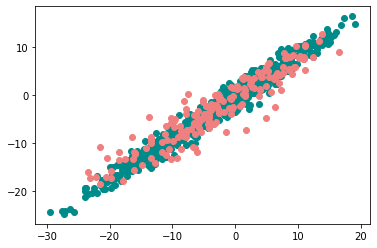

In [75]:
# clf = ExtraTreesRegressor(n_estimators=50, max_depth=8, n_jobs=4, random_state=12345, bootstrap=True, oob_score=True)
# clf.fit(x_train, y_train)
# print(f'The goodness-of-fit is {clf.oob_score_}.')
# test_preds = clf.predict(x_test)
# train_preds = clf.predict(x_train)
# show_plot(train_preds, y_train, test_preds, y_test)

/home/gonzales72/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The goodness-of-fit is 0.9215141735980409.


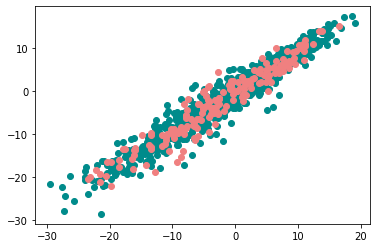

In [74]:
# clf = MLPRegressor()
# clf.fit(x_train, y_train)
# print(f'The goodness-of-fit is {clf.score(x_test, y_test)}.')
# test_preds = clf.predict(x_test)
# train_preds = clf.predict(x_train)
# show_plot(train_preds, y_train, test_preds, y_test)

The goodness-of-fit is 0.8341147640130518.


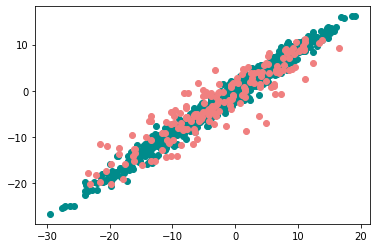

In [73]:
# clf = RandomForestRegressor(n_estimators=50, max_depth=8, random_state=12345)
# clf.fit(x_train, y_train)
# print(f'The goodness-of-fit is {clf.score(x_test, y_test)}.')
# test_preds = clf.predict(x_test)
# train_preds = clf.predict(x_train)
# show_plot(train_preds, y_train, test_preds, y_test)

The goodness-of-fit is 0.8158775609361482.


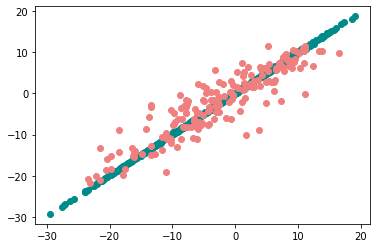

In [72]:
# clf = GradientBoostingRegressor(n_estimators=50, max_depth=8, random_state=12345)
# clf.fit(x_train, y_train)
# print(f'The goodness-of-fit is {clf.score(x_test, y_test)}.')
# test_preds = clf.predict(x_test)
# train_preds = clf.predict(x_train)
# show_plot(train_preds, y_train, test_preds, y_test)

Want to make these models better? Consider hyperparameter tuning! Each of the methods above have keyword arguments for their hyperparameters that you can change the value of to see how the model's performance improves or declines. Consider looking over the source documents to learn more about the hyperparameters you can tune:
* [Extra Trees Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html)
* [MLP Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)
* [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
* [Gradient Boosting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)

Reviewed and Released: LLNL-PRES-832485